In [ ]:
#import plikuj kaggle.json
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 700 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d joosthazelzet/lego-brick-images

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
100% 0.99G/1.00G [00:50<00:00, 17.9MB/s]
100% 1.00G/1.00G [00:50<00:00, 21.4MB/s]


In [5]:
!unzip -qq lego-brick-images.zip -d legoBrick

In [6]:
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [7]:
data_dir = "legoBrick"
dataset_dir = os.path.join(data_dir, "dataset")
validation_txt_path = os.path.join(data_dir, "validation.txt")
train_dir = os.path.join(data_dir, "train_data")
val_dir = os.path.join(data_dir, "validation_data")

In [8]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

#odczyt jakie pliki są walidacyjnymi
with open(validation_txt_path, 'r') as file:
    val_files = file.read().splitlines()

#pliki walidacji to val_dir
for file in val_files:
    file_path = os.path.join(dataset_dir, file)
    if os.path.isfile(file_path):
        shutil.move(file_path, os.path.join(val_dir, file))
    else:
        print(f"File '{file}' not found in '{dataset_dir}'")

print("Przeniesiono pliki walidacyjne.")

#pozostale pliki do train_dir
remaining_files = os.listdir(dataset_dir)
for file in remaining_files:
    file_path = os.path.join(dataset_dir, file)
    if os.path.isfile(file_path):
        shutil.move(file_path, os.path.join(train_dir, file))

print("Podzielono dane pomyślnie.")

Przeniesiono pliki walidacyjne.
Podzielono dane pomyślnie.


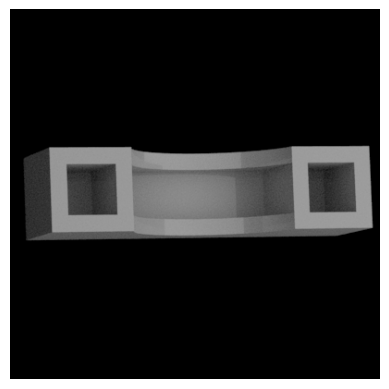

In [9]:
train_data_dir = "legoBrick/train_data"
image_file = os.listdir(train_data_dir)[0]

image_path = os.path.join(train_data_dir, image_file)

# Wyświetl obraz
image = plt.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
#tworzenie podkatalogów klas i przenoszenie
def organize_into_classes(directory):
    files = os.listdir(directory)
    for file in files:
        if os.path.isfile(os.path.join(directory, file)):
            #weź tylko nazwę klasy z pliku
            class_name = file.split()[0]
            class_dir = os.path.join(directory, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.move(os.path.join(directory, file), os.path.join(class_dir, file))

#zastosuj na katalogach
organize_into_classes(train_dir)
organize_into_classes(val_dir)

In [11]:
# załaduj do zbioru danych tensorflow określona wielkość próbki
batch_size = 32
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(128, 128),
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(128, 128),
    shuffle=False
)

#pozyskiwanie nazw klas
class_names = train_dataset.class_names
num_classes = len(class_names)

# wstępne przetwarzanie do odpowiedniej wielkości
def load_and_preprocess_image(image, label):
    image = tf.image.resize(image, (128, 128))  # zmien obrazy na staly rozmiar
    image = tf.cast(image, tf.float32) / 255.0  # wartosc pixela do przedzialu [0,1]
    return image, label

#przetworz datasety
train_dataset = train_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)

Found 32000 files belonging to 50 classes.
Found 8000 files belonging to 50 classes.


In [14]:
# Definicja modelu
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='swish', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='swish'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='swish'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='swish'),
    tf.keras.layers.Dense(num_classes)
])

# Kompiluj model (z odpowiednimi funkcjami straty i optimizerem)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f" Epoch {epoch+1}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}, Val Loss: {logs['val_loss']}, Val Accuracy: {logs['val_accuracy']}")

# Trenuj model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[CustomCallback()])

Epoch 1/10
1000/1000 [==============================] - 1049s 1s/step - loss: 2.1109 - accuracy: 0.3562 - val_loss: 1.7411 - val_accuracy: 0.4442
Epoch 2/10
1000/1000 [==============================] - 1004s 1s/step - loss: 1.3595 - accuracy: 0.5592 - val_loss: 1.5509 - val_accuracy: 0.5150
Epoch 3/10
1000/1000 [==============================] - 1023s 1s/step - loss: 0.8763 - accuracy: 0.7113 - val_loss: 1.7615 - val_accuracy: 0.5235
Epoch 4/10
1000/1000 [==============================] - 1009s 1s/step - loss: 0.5528 - accuracy: 0.8110 - val_loss: 2.1437 - val_accuracy: 0.5236
Epoch 5/10
1000/1000 [==============================] - 1010s 1s/step - loss: 0.3891 - accuracy: 0.8694 - val_loss: 2.4932 - val_accuracy: 0.5390
Epoch 6/10
1000/1000 [==============================] - 995s 995ms/step - loss: 0.3198 - accuracy: 0.8912 - val_loss: 2.8229 - val_accuracy: 0.5355
Epoch 7/10
1000/1000 [==============================] - 1023s 1s/step - loss: 0.2662 - accuracy: 0.9097 - val_loss: 2.9032

funkcja aktywacyjna relu dokładność na poziomie: 96% ,  czas nauki:3h20min


funkcja aktywacyjna swish dokładność na poziomie: 93,3%, czas nauki:1h40min

---



Stwierdziłem, że do mojego datasetu nie będę testował funkcji aktywacji  elu (brak negatywnych wartości w moim modelu) i tahn (wykrywanie wartości z zakresu od -1 do 1)

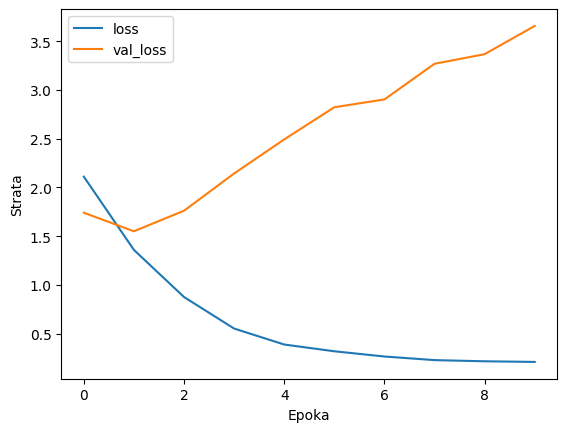

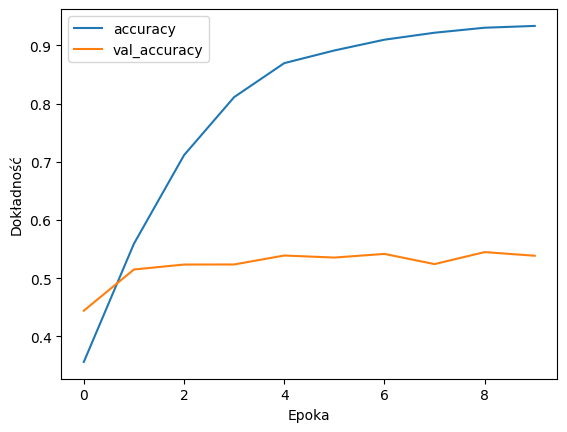

250/250 - 80s - loss: 3.6572 - accuracy: 0.5386 - 80s/epoch - 321ms/step

Dokładność walidacji: 0.5386250019073486


In [26]:
# Rysowanie straty i dokładności
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

# Ocena modelu
test_loss, test_acc = model.evaluate(val_dataset, verbose=2)
print('\nDokładność walidacji:', test_acc)

# Zapis modelu
model.save('lego_brick_classifier.keras')

1/1 [==============================] - 0s 30ms/step


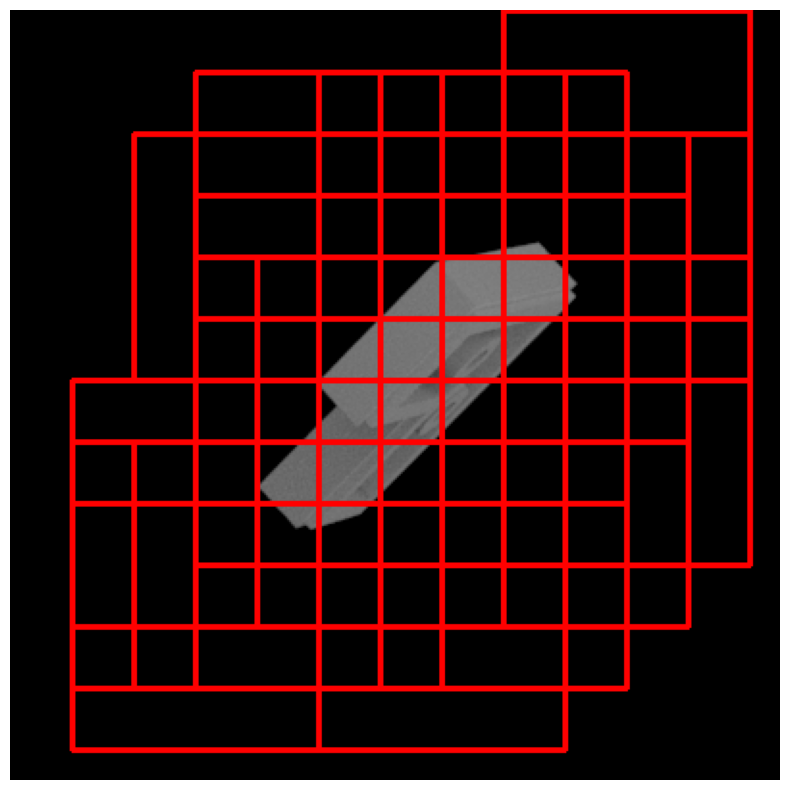

In [27]:
def detect_and_draw_boxes(image_path, step_size=32, window_size=(128, 128), model_path='lego_brick_classifier.keras'):
    # Wczytaj model
    model = tf.keras.models.load_model(model_path)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = []

    for (x, y, window) in sliding_window(image_rgb, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue

        window_preprocessed = preprocess_image(window)
        window_preprocessed = np.expand_dims(window_preprocessed, axis=0)

        predictions = model.predict(window_preprocessed)
        predicted_class = np.argmax(predictions[0])
        confidence = tf.nn.softmax(predictions[0])[predicted_class]

        # Jeżeli spełnia warunek wykryj obiekt
        if confidence > 0.8:
            boxes.append((x, y, x + window_size[0], y + window_size[1]))

    # Stwórz obraz z zaznaczonymi tylko wykrytymi obiektami
    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(image_rgb, (startX, startY), (endX, endY), (255, 0, 0), 2)

    # Pokaż obraz z zaznaczonymi obiektami
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Wyłącz osie
    plt.grid(False)  # Wyłącz siatkę
    plt.show()

detect_and_draw_boxes('legoBrick/train_data/14719/14719 flat tile corner 2x2 080L.png')
